<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Started

As before, we'll import the packages we'll need in this notebook. Most of these are the same as the previous notebook, but there are a few new ones.

In [1]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

Let's print out the versions of our packages again. If we come back to this later, we'll know what we used.

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
matplotlib version: 3.9.2
pandas version: 2.2.3
PIL version: 10.2.0
torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


We should be running on GPUs, so the device should be `cuda`.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Reading files

We'll need to read in our data. Since we'll be using images once again, we'll need to convert them to something our network can understand. To start with, we'll use the same set of transformations we used in the previous notebook.

These transformations are
- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$, but other sizes would work as well)
- Convert the image to a Tensor of pixel values

This should result in each image becoming a Tensor of size $3$ x $224$ x $224$. We'll check this once we read in the data.

In [4]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [5]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In the previous notebook, we were working with only two categories. That data was in the `data_binary` subdirectory. Here we'll work with all eight categories, in the `data_multiclass` subdirectory. Let's load that data. We will follow the same pattern we used in the last notebook.

**Task 1.4.1:** Assign the path to the multi-class training data to `train_dir`. Then use the `ImageFolder` tool to open those files and apply our transforms.

In [6]:
data_dir = "data_p1/data_multiclass"
train_dir = os.path.join(data_dir, "train")

print("Will read data from", train_dir)

Will read data from data_p1/data_multiclass/train


In [7]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

Now that we have our data, let's verify that we got what we wanted. We should have classes for each of the seven animals, and one `'blank'` for when there wasn't an animal in the image. Additionally, the tensors we get should be of size $3$ x $224$ x $224$.

In [8]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
That's 8 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In principle, we could work with the data like this. But PyTorch is expecting the data to be broken into batches with a `DataLoader`. This prevents PyTorch from trying to load all of the files into memory at once, which would cause our notebook to crash. Instead, it loads just a few (the `batch_size`), works with them, then discards them. Since all the tools are expecting it, we should convert ours. The batch size to work with will depend on our system, but something in the $20$ to $100$ range is usually fine. We'll pick $32$.

In [9]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


When we loop over this loader, it'll produce small batches of our images. This is what we want — these are the "minibatches" that will speed up our computations. In our case, each batch is $32$ images, with each image $3$ x $224$ x $224$. It also provides us with the labels for the correct answers. This is the information we need to train a network.

<div class="alert alert-info" role="alert">
We're going to be cheating a bit here. Technically, we should divide our data into a training set and validation set right now. Then we should do all of our work on just the training set. This prevents information from the validation set leaking into the training set. But the way that PyTorch organizes its data loading makes that much more difficult than what we're going to do. We're going to do one simple transformation to our data, then do the test-validation split. If we were doing anything more complicated, we'd have to be more careful.
</div>

### Preparing Our Data

As we were reading in the data, we already did some preparation. Our images are all the same shape, and have been converted to tensors. But neural networks tend to perform best with data that has a mean of $0$ and a standard deviation of $1$. Data that has that property is called _normalized_. In our case, that would be the mean and standard deviation of all of the pixels in all of the images.

Let's see what they are for our data. Here's a function that computes the mean and standard deviation for each color channel (red, green, and blue) separately. It takes in a `DataLoader` and returns the mean and standard deviation of each channel.

In [10]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

**Task 1.4.2:** Run the `get_mean_std` function. on the training data, and save the means and standard deviations to variables `mean` and `std`. There should be a value for each color channel, giving us vectors of length $3$.

In [11]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/516 [00:00<?, ?it/s]

Mean: tensor([0.4788, 0.4925, 0.4833])
Standard deviation: tensor([0.2541, 0.2470, 0.2501])


Now that we have these values, we can adjust our pixels. To get mean $0$, we need to subtract our measured `mean` from every pixel. To get standard deviation $1$, we divide every pixel by the `std`. 

We can perform these calculations using the `Normalize` transformation that `torchvision` gives us. We'll add it as an extra step to the transform we created earlier. Since we're doing the three color channels separately, we'll nave to give `Normalize` a vector with three means (and the same for standard deviation). Conveniently, that's what we have.

In [12]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

**Task 1.4.3:** Make a new normalized dataset using `ImageFolder` and a new `DataLoader`.

In [13]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)

norm_loader =  DataLoader(norm_dataset, batch_size=batch_size)

If this did what we wanted, the normalized data should have mean $0$ and standard deviation $1$ in each color channel.

**Task 1.4.4:** Use the `get_mean_std` function to verify the mean and standard deviation are correct in the `norm_loader` data.

In [14]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/516 [00:00<?, ?it/s]

Mean: tensor([-2.2570e-07, -7.9987e-07, -1.4907e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


The means may not be _exactly_ zero due to machine precision. But they should be extremely small.

<div class="alert alert-info" role="alert">
This sort of "rounding error" is extremely common when working with floating point numbers on a computer. The computer only stores a certain number of digits after the decimal point. This rounding means that math operations sometimes don't get the last few digits right. This becomes very obvious when you subtract two numbers that should be the same. If the last digits in the two numbers are different because of this rounding, you won't get zero, you'll get that last digit leftover.

As an example, $\frac{1}{3} - \frac{1}{5} = \frac{2}{15}$. But the following cell doesn't quite give you zero.
</div>

In [15]:
1 / 3 - 1 / 5 - 2 / 15

-2.7755575615628914e-17

### Train and validation splitting

As always, we'll need to divide our data into two parts. We'll train our data on some of our images, and reserve some of them for validation. This will let us see how our model does on images it hasn't seen before. If it makes good predictions on the training data but not on the validation data, we'll know it has overfit.

**Task 1.4.5:** Use `random_split` to create a training dataset with 80% of the data, and a validation dataset with 20% of the data. Be sure to use the normalized data.

In [16]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8,0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


We want the training data and validation data to be similar. Ideally, the random split should do that for us. But with multiple categories, it's possible we have too much of one category ending up in training or validation.  For example, we could have gotten really unlucky and wound up with all of our leopards in the validation set. 

We should check how many of each category we have in each of our data sets. We aren't expecting the same _number_ of each. The different categories started with different amounts, and the training set is $4$ times as big. But we should expect the training and validation sets to have the same _proportion_ of each category.

As we did in the last notebook, we can visualize this with a bar chart. We'll use the same function as last time.

In [17]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

We can use it to see how many of each category in our training dataset.

In [18]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions

  0%|          | 0/13191 [00:00<?, ?it/s]

antelope_duiker     1950
bird                1331
blank               1774
civet_genet         1928
hog                  790
leopard             1823
monkey_prosimian    1987
rodent              1608
dtype: int64

Useful, but visualizations are much easier for humans to understand. Let's make that bar plot.

**Task 1.4.6:** Create a bar plot from these counts. We did this in the previous notebook.

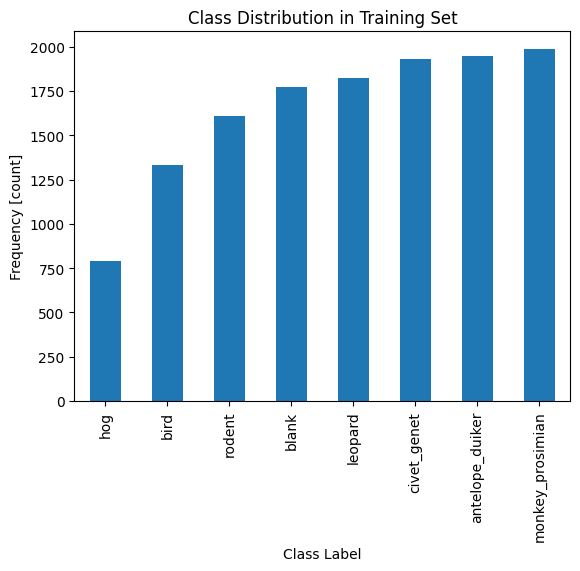

In [19]:
# Create a bar plot from train_class_distribution
train_class_distributions.sort_values().plot(kind='bar')

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

Now we can repeat this for the validation set and compare them by eye.

**Task 1.4.7:** Make the same graph for the validation data.

  0%|          | 0/3297 [00:00<?, ?it/s]

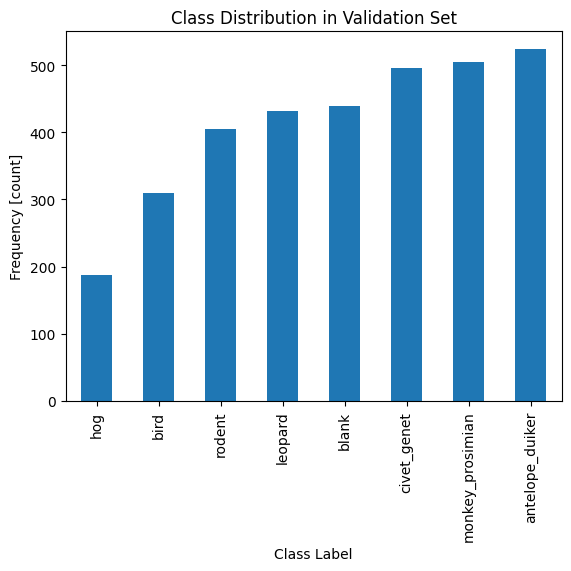

In [20]:
# Get the class distribution
validation_class_distributions = class_counts(val_dataset)

# Create a bar plot from train_class_distribution
validation_class_distributions.sort_values().plot(kind='bar')

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");

The two graphs should look similar, though they won't be identical. The random process always produces some differences. If they are _too_ different, you can run your train-validation split again to get a better balance. If you do this, remake the graphs to make sure they're actually better.

<div class="alert alert-info" role="alert">
With a little bit more work, you can put the two bar graphs together into one graph. This would make them easier to compare. You could do this by combining the two pandas Series into one DataFrame. But if you do, make sure you change the counts into fractions — we have many more points in our training set! The easiest way to do that is to divide each Series by its total counts (its sum).
</div>

Now that we're happy with our split, we'll need to make a `DataLoader` again. We'll need separate ones for the training and validation sets. But for the training data, we'll want it to be shuffled every time we run it. As in the previous notebook, we'll add `shuffle=True` to the arguments. We won't want the validation set shuffled.

**Task 1.4.8:** Create data loaders for the train and validation sets. Use a batch size of $32$. Be sure to turn on shuffling for the training set.

In [21]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)


batch_size = batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


# A Better Model

### Multiclass Predictions

With our data in hand, we're ready to address our task. As in the last notebook, we want a model that will take a picture, and tell us what's in it. But this time, instead of just "hog" or "not hog", we want it to tell us which animal is in the image. This makes it a _multiclass_ classification problem.

Now we're going to have our model give a confidence for _each_ class. This will give us $8$ values. As before, higher numbers mean that the model is more confident that class is the right answer. A possible output for a single image would be the following.

In [22]:
sample_confidence = torch.tensor([0.13, 0.01, 0.02, 0.12, 0.10, 0.34, 0.16, 0.12])

Our prediction in this case would be the category with the highest confidence. These categories appear in the order set in the dataset. We can find which one is the largest using `argmax`, as we did in the previous notebook. 

**Task 1.4.9:** Find which animal we should predict, using `argmax` and the list of classes.

In [23]:
classes = norm_dataset.classes

class_number = torch.argmax(sample_confidence)
prediction = classes[class_number]

print(f"This image is a {prediction}")

This image is a leopard


<div class="alert alert-info" role="alert">
You may notice that these numbers sum to $1$ (try it!). Most tools for doing machine learning produce outputs like this. You will often hear this referred to as the "probability" of each class. That the model thinks there's a $13\%$ chance it's class $0$, a $1\%$ chance it's a class $1$, etc.
</div>

In our training data, we also already know the correct class. Our model will generate a set of $8$ confidence values for each image, which we can use to make predictions. We can compare these predictions to the right answer to find out how well the model has done.

### Network Architecture

Now we need a model. We'll build another neural network. The one we built last time was a shallow neural network. This is a network made of a sequence of "dense" or "fully connected" layers. But that's not the only option! You can connect the neurons in different ways, to get different _architectures_.

The shallow neural network is the "standard", most common one. We could use it for our problem, but to get good accuracy we'd need to add more layers. That network would take a long time to train. We'll be better served by using an architecture meant for images. 

A good option, and the one we'll use, is the convolutional neural network (CNN). It consists of a sequence of convolutional and max pooling layers. These are usually followed by some fully connected layers and an output layer.

### Convolution and Max Pooling Layers

The CNN gets its name from the convolutional layers. These layers take in an image, maintaining the 2D structure, and convolve it with a number of kernels. Each kernel will produce a new image. Thankfully, PyTorch will do all the math and tracking for us. Just like we had `Linear` layers before, we can get a convolutional layer by adding a `Conv2D` to our model.

As before, we'll use a `Sequential` model to keep track of how to build things.

In [24]:
model_seq = torch.nn.Sequential()

To create a convolution layer, we need to provide it with three arguments: the number of channels it expects as input, the number of kernels to create, and the size of those kernels. We don't have to specify the size of the images, it'll figure that out. 

This first layer will be looking at our input images. They have three color channels, so we set `in_channels=3`. For our kernels, let's start with $16$ kernels of size $3$ x $3$. We specify the kernel size with `kernel_size=(3,3)`, and the number of kernels with `out_channels=16`. We'll also need padding to keep our image size. With a $3$ x $3$ kernel, we'll set padding to $1$.

In [25]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
model_seq.append(conv1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Let's also get a single batch of $32$ images, so we can see what the model is doing.

In [26]:
test_batch = next(iter(train_loader))[0]

Let's make sure the batch is the shape we expect. It should be $32$ images, with $3$ color channels, of size $224$ x $224$.

**Task 1.4.10:** Get the shape of the batch and store it to `batch_shape`. 

In [27]:
batch_shape = test_batch.shape

print(f"Batch shape: {batch_shape}")

Batch shape: torch.Size([32, 3, 224, 224])


Now we can run the model we have so far on the data. Since we only have the one convolutional layer, we'll see its output.

This is a useful trick for making sure we're getting what we expect. What _do_ we expect here? We should still have $32$ images, but now they should have $16$ channels corresponding to the $16$ kernels.

In [28]:
first_step_out = model_seq(test_batch)

**Task 1.4.11:** Get the shape of the output and store it to `first_step_shape`.

In [29]:
first_step_shape = first_step_out.shape

print(f"Shape after first convolution layer: {first_step_shape}")

Shape after first convolution layer: torch.Size([32, 16, 224, 224])


As always with a network, we'll need an activation function. Here we'll use the ReLU like we did in the previous notebook.

In [30]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

<div class="alert alert-info" role="alert">
Be careful here. When we append to our Sequential model, we're modifying it. If we run the cell again, this will add a second ReLU layer. Not what we want! There are other ways to organize the model creation that don't have this problem. But the simplest thing would be to build your whole model in one cell. That way, when you re-run it, it starts from scratch.
</div>

Our convolution layers transform images into more images. Ultimately, we're going to need to get down to just our $8$ output classes. But our convolution has _increased_ the number of pixels! Max pooling will let us shrink our image.

In PyTorch, this is a `MaxPool2D` layer. The 2D is because we're leaving the channels alone, so it'll max pool on each of our $16$ channels separately. We'll need to say how big of a patch to reduce, called the kernel again. We'll set it to $2$ x $2$, a standard choice. We'll set our stride to $2$ as well.

In [31]:
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

Let's verify that this did what we wanted. It should have left us with $32$ images, with $16$ channels, but half as large.

**Task 1.4.12:** Run the current model on the `test_batch`, and save the output's shape to `max_pool_shape`.

In [32]:
max_pool_out = model_seq(test_batch)
max_pool_shape = max_pool_out.shape

print(f"Shape after first max pool: {max_pool_shape}")

Shape after first max pool: torch.Size([32, 16, 112, 112])


This sequence of convolution, ReLU, max pool is very common in CNNs. Often networks will have several of these in a row. Let's add two more to ours.

**Task 1.4.13:** Add a convolution layer taking in our $16$ channels and outputting $32$ channels, with a $3$ x $3$ kernel and padding of $1$. Follow that with a ReLU, and a max pool of size $2$ x $2$.

In [33]:

model_seq.append(torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

And, as always, let's verify the shape. What should we expect this time?

**Task 1.4.14:** Run the current model on the `test_batch`, and save the output's shape to `second_set_shape`.

In [34]:
second_set_out = model_seq(test_batch)
second_set_shape = second_set_out.shape

print(f"Shape after second max pool: {second_set_shape}")

Shape after second max pool: torch.Size([32, 32, 112, 112])


If things went according to plan, you should now have $32$ channels and a $56$ x $56$ image.

You can actually simplify these descriptions. First, you don't have to provide the argument names for most things, IF you provide them in the right order (`padding` is an exception). Second, for the kernels, if you say $2$ it knows you mean $2$ x $2$ (same for $3$, etc). Finally, for the max pool you can leave off the stride, it defaults to the size of the kernel. We can use this to make the description of our third layer set more compact. We'll use $64$ kernels this time.

In [35]:
conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.MaxPool2d(2))
model_seq.append(conv3)
model_seq.append(torch.nn.ReLU())
model_seq.append(max_pool3)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

**Task 1.4.15:** Run the current model on the `test_batch`. Save the output's shape to `third_set_shape`.

In [36]:
third_set_out = model_seq(test_batch)
third_set_shape = third_set_out.shape

print(f"Shape after third max pool: {third_set_shape}")

Shape after third max pool: torch.Size([32, 64, 28, 28])


We should now have a $32$ x $64$ x $28$ x $28$. We could keep adding more of these sets of layers, but this should be plenty. Now we need to move toward getting our final $8$ classes.

### Finishing the model

We're going to need an output layer with just $8$ neurons. That's a flat output, without the 3D structure of our images. Conveniently, PyTorch provides a `Flatten` layer for flattening. Let's add that to our model.

In [37]:
model_seq.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

What shape should we expect now? It should be our batch size of $32$ by however many pixels we had. This layer has just taken all our pixels and laid them out into a big vector. How many is that?

In [38]:
64 * 28 * 28

50176

Once again, then we can use the model to make sure we've got it right.

**Task 1.4.16:** Run the current model on the `test_batch`. Save the output's shape to `flat_shape`.

In [39]:
flat_out = model_seq(test_batch)
flat_shape = flat_out.shape

print(f"Shape after flattening: {flat_shape}")

Shape after flattening: torch.Size([32, 50176])


At this point we have a flat input, and can build a normal set of dense layers. You can think of the convolution/max pool layers as having done the image processing. Now we need to do the actual classification. It turns out that dense layers are good at that task.

We could add a single layer and just go straight to our output $8$ classes. But we'll get better performance by adding a few dense layers, `Linear` in PyTorch's terminology, first. For these layers, we need to tell it the size of the input, and how many neurons we want in the layer. Since the input is our previous layer, we tell it that size. We'll add a layer of $500$ neurons.

In [40]:
linear1 = torch.nn.Linear(in_features=50176, out_features=500)

model_seq.append(linear1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
)

**Task 1.4.17:** Add the ReLU activation layer.

In [41]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
)

And now we should be getting an output shape from the $500$ neurons.

In [42]:
linear_out = model_seq(test_batch)
linear_shape = linear_out.shape

print(f"Shape after linear layer: {linear_shape}")

Shape after linear layer: torch.Size([32, 500])


We could add more of these, but this network has already gotten rather large. Let's put in the final layer on. We'll need a dense layer with $8$ outputs. But this time we don't add the activation function. We need something different for the final layer.

**Task 1.4.18:** Add the output dense layer.

In [43]:
output_layer = torch.nn.Linear(in_features=500, out_features=8)

model_seq.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=8, bias=True)
)

And one final shape check. If everything has gone according to plan, we should be getting $8$ outputs for each of our input images, giving us a $32$ x $8$ tensor on our test batch.

In [ ]:
model_seq(test_batch).shape

torch.Size([32, 8])

That's the model! We're finally done. Now we need to train it.

### Training the Model

Before we start training, let's put all the model code in one place. This is how you'd do it in practice, to prevent errors.

We have also added `Dropout` layers after the flattened and linear layers. This helps to prevent overfitting.

In [ ]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 8)
model.append(output_layer)

And to make sure PyTorch has the model correct, let's look at the summary.

In [ ]:
height, width = 224, 224

summary(model, input_size=(batch_size, 3, height, width))

This model has over 25 million parameters. That's fewer than our previous model, but because of the more complicated architecture it'll take more time and resources to train.

We can use the same training code we used last time. It can handle binary or multiclass classification. We made a separate file with this code in the previous notebook. Now we can reuse that code by importing it.

In [ ]:
from training import predict, train

As in the previous notebook, we'll use the cross entropy as our loss function. This will take into account how confident the model is in its answer, as well as whether it was right or wrong. We will also print the accuracy as a human-readable measure.

We'll need to set up our Cross Entropy loss, and an optimizer. We'll also make sure our model is on the GPU.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

And away we go! This is exactly the same code as last time, so it's called the same way.

**Task 1.4.19:** Train the model for $8$ epochs.

<div class="alert alert-info" role="alert"> <strong>Regarding Model Training Times</strong>

This task involves training a neural network for 8 epochs. As highlighted in the accompanying video, the training process is computationally intensive and can be very time-consuming. On most systems, each epoch may take between 10 and 15 minutes, meaning the entire training process could last well over one hour. In an online lab, this could result in timeouts or interruptions.
To streamline your learning experience, where the video omits over an hour of training footage, we have provided a pre-trained model for your convenience. This model is an exact replica of the one you have been working on, trained for 8 epochs and carefully serialized using <code>torch.save()</code>.
Upon completing the video for Task 1.4.19, you can proceed by loading the pre-trained model using the following cell.
</div>

In [ ]:
train(...)

**Pretrained Model:** Load the pre-trained model with the following line:

In [ ]:
model = torch.load("model/trained_model.pth", weights_only=False)

<div class="alert alert-info" role="alert">
We've chosen to train for eight epochs. This was pretty arbitrary. We wanted to get a decent result without running for too long. If the validation loss is still decreasing, the model is still improving. In that case, we may benefit from training longer. As models get larger, they generally take longer to train. Thankfully, training more doesn't restart the process. We could just run the training function again and it'll pick up where it left off.
</div>

As we did in the previous notebook, we can use our predict function to get the confidence values, and convert them to predictions.

**Task 1.4.20:** Calculate the predictions for the validation set.

In [ ]:
probabilities = ...
predictions = ...

With those and the correct answers, we can generate the confusion matrix. Let's pull the targets into a list.

In [ ]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

**Task 1.4.21:** Make the same confusion matrix we made last time. You'll need to either move the `predictions` to `cpu` or convert them to a list. The labels will be our classes.

In [ ]:
cm = ...

disp = ...

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

We're doing at least as well as our binary classification, but this time with many more animal choices. It seems some animals are a bit more difficult to distinguish from the `'blank'` images.

### Submission to competition

Now we can use our model to complete the competition. They want our model's confidences for each of the $8$ classes on a test set. We don't know the answer here (it wouldn't be much of a competition if we did!). We'll need to run each image through our model.

They want the results saved as a csv file, with the columns labeled by the class, and the row index with a special ID. They've given us a file saying how these IDs map to image files. This will be easiest for us to save as a DataFrame.

First, we need to read in the IDs and filenames. All of the test data is in the `data_multiclass/test` directory, and this ID mapping is in the `test_features.csv` file.

**Task 1.4.22:** Read in the ID mapping csv file with pandas.

In [ ]:
test_dir = os.path.join(data_dir, "test")

# Read the CSV file
id_file_location = ...
df_ids = ...

df_ids.head()

The ID is really just the filename without the `.jpg` on the end, and all of the images are in the `test_features` subdirectory of the test directory.

Let's run our model on one of the images. We can get the file location from our DataFrame.

In [ ]:
test_image_location = df_ids.iloc[0, 1]
test_image_location

This is the location within our test folder. Let's open the image and look at it.

**Task 1.4.23:** Use `PIL` to open this image and assign it to `test_image`.

In [ ]:
test_image_path = ...
test_image = ...
test_image

Our model is expecting images that have had our transformations applied. This is thankfully easy to do.

In [ ]:
test_image_trans = transform_norm(test_image)
test_image_trans.shape

Almost there. Our model is actually expecting a batch of these. Since we only have one, we'll need to change the tensor to a $1$ x $3$ x $224$ x $224$. We could do this with `reshape`, but it's easier to use `unsqueeze`. `unsqueeze` is meant for this exact problem. It adds an extra dimension with one element. We just specify _which_ extra dimension we want. In our case, we want the first dimension (i.e. `0`) to be the extra one.

In [ ]:
test_unsqueeze = test_image_trans.unsqueeze(0)
test_unsqueeze.shape

Now we run our model on this. Since our model is on the GPU now, we'll need to move this image there too.

In [ ]:
test_image_cuda = test_unsqueeze.to(device)
test_out = model(test_image_cuda)
test_out

That's the model's predictions, but it's not in the form we expected. We want a set of numbers between $0$ and $1$, that sum to $1$. What we're seeing is the raw output of the last layer. To convert this to the confidences, we need to run it through a `SoftMax`. This is very much like the logistic or sigmoid you've seen before, except that it works with many inputs. The `dim=1` tells it each row is one prediction.

In [ ]:
test_softmax = torch.nn.functional.softmax(test_out, dim=1)
test_softmax

Now that we have our numbers, we need to convert to a DataFrame. The predictions are made in the same order as the classes in our dataset. We can't convert a tensor directly to a DataFrame, so we'll convert it to a list first. Then we can set the columns to our classes.

In [ ]:
test_df = pd.DataFrame(test_softmax.tolist())
test_df.columns = dataset.classes

test_df

We also should set the index to the ID.

In [ ]:
image_id = df_ids.iloc[0, 0]
test_df.index = [image_id]

test_df

And we're ready to go. Let's put this into a function to make it easier. We'll also add a few things to make PyTorch run faster.

In [ ]:
model.to(device)


def file_to_confidence(file_path, image_id):
    image = PIL.Image.open(file_path)
    transformed = transform_norm(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame(confidence.tolist())
    conf_df.columns = dataset.classes
    conf_df.index = [image_id]

    return conf_df

Let's make sure the function works as expected. We should get the same result as before. Note that the function is expecting the full file path.

In [ ]:
file_to_confidence(test_image_path, image_id)

Now we can use this function on each file to get the predictions. We can loop over the ids and filenames and build up a DataFrame.

**Task 1.4.24:** Do it! You can use `df_ids.itertuples()` to get one row at a time, and `pd.concat` to assemble many DataFrames into one big one.

In [ ]:
confidence_df = ...

Finally, the competition wants this as a csv. We can save a pandas DataFrame directly to a csv.

In [ ]:
confidence_df.to_csv("submission.csv")

### Saving the Model

We've put a lot of effort into this model, and it took a while to train. The training has determined what the best parameters (also called weights) for our network. The only information we need to reproduce it's the network architecture, and the values of those parameters. PyTorch lets us save all of this. Then we can just load the model in the future instead of having to retrain it.

In [ ]:
torch.save(model, "model/deepnet")

### Conclusion

Good work! This was a long one, but we covered a lot of important ideas. We're now able to use PyTorch to classify any number of images, with any number of classes! Here are the key takeaways:

- Some preprocessing of our images, or data in general, can help our models.
- In multiclass classification, we get a confidence for each of our classes.
- Neural networks can have different ways of connecting their neurons, called architectures
- The Convolutional Neural Network architecture does well on images
- In PyTorch, we can build one by choosing different layers
- With a trained model, we can predict the class of an unlabeled image

All together, this let us complete the competition we have been working on. We now have a model that gives us confidences (and thus predictions) on what animals appear in a camera trap image.

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).